In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import copy
from datetime import datetime, timedelta
# import visualkeras
# import tensorflow as tf
from sklearn.metrics import balanced_accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import sys
import os
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import glob 

In [2]:
from sklearn.decomposition import PCA
from scipy.stats import chi2_contingency

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cartopy.feature as cf
import shapely.geometry as sgeom

In [3]:
path_weekly_anoms = '/glade/derecho/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd_v3_2dg/'
files_weekly_anoms = np.sort(glob.glob(f'{path_weekly_anoms}/*.nc'))

In [4]:
files_weekly_anoms

array(['/glade/derecho/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd_v3_2dg/IC_SODA.nc',
       '/glade/derecho/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd_v3_2dg/IT_SODA.nc',
       '/glade/derecho/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd_v3_2dg/MLD_SODA.nc',
       '/glade/derecho/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd_v3_2dg/OHC100_SODA.nc',
       '/glade/derecho/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd_v3_2dg/OHC200_SODA.nc',
       '/glade/derecho/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd_v3_2dg/OHC300_SODA.nc',
       '/glade/derecho/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd_v3_2dg/OHC50_SODA.nc',
       '/glade/derecho/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd_v3_2dg/OHC700_SODA.nc',
       '/glade/derecho/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd_v3_2dg/OLR_ERA5.nc',
       '/glade/derecho/scratch/jhayron/Data

# Iterate through all variables

In [5]:
for ifile in range(len(files_weekly_anoms)):
    print(ifile,files_weekly_anoms[ifile])

0 /glade/derecho/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd_v3_2dg/IC_SODA.nc
1 /glade/derecho/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd_v3_2dg/IT_SODA.nc
2 /glade/derecho/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd_v3_2dg/MLD_SODA.nc
3 /glade/derecho/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd_v3_2dg/OHC100_SODA.nc
4 /glade/derecho/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd_v3_2dg/OHC200_SODA.nc
5 /glade/derecho/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd_v3_2dg/OHC300_SODA.nc
6 /glade/derecho/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd_v3_2dg/OHC50_SODA.nc
7 /glade/derecho/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd_v3_2dg/OHC700_SODA.nc
8 /glade/derecho/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd_v3_2dg/OLR_ERA5.nc
9 /glade/derecho/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd_v3_2dg/SD_ERA5.nc
10 /glade/derecho/s

In [6]:
path_eofs = 'PC_Data/EOFs/'
path_pcs = 'PC_Data/PCs/'

In [7]:
for ifile in range(len(files_weekly_anoms)):
    file_temp = files_weekly_anoms[ifile]
    dataset = xr.open_dataset(file_temp)
    var_name = list(dataset.data_vars.keys())[0]
    print(file_temp,var_name)
    dataset = dataset.load()
    
    name_var = file_temp.split('/')[-1][:-3]
    
    ### Find and drop useless (always zero, pixels)
    flattened_da = dataset.stack(flat=('lat','lon')).transpose('time','flat')[var_name]
    nan_mask = flattened_da.isnull().all(dim='time')
    # nan_mask = flattened_da.isnull().any(dim='time')
    where_nonan = np.where(nan_mask==False)[0]
    flattened_nonan = flattened_da[:,where_nonan]
    flattened_nonan = flattened_nonan.fillna(0)
    
    # create pca object
    pca_obj = PCA(150, whiten=True)##
    pca_obj = pca_obj.fit(flattened_nonan)
    n_pcs = len(np.where(np.cumsum(pca_obj.explained_variance_ratio_) * 100<=80)[0])
    pca_obj = PCA(n_pcs, whiten=True)##
    pca_obj = pca_obj.fit(flattened_nonan)
    
    # transform era5 data with pca
    transformed_da = pca_obj.transform(flattened_nonan)
    
    print(f'Variance explained: {pca_obj.explained_variance_ratio_ * 100}')
    print(f'Cumulative sum of variance explained for EOF1 and EOF2: {np.cumsum(pca_obj.explained_variance_ratio_) * 100}')
    transformed_da = pd.DataFrame(transformed_da,index = dataset.time)
    
    eofs = []
    for ipc in range(transformed_da.shape[1]):
        pc_flattened_nonan = copy.deepcopy(flattened_nonan.isel(time=0))#.values
        # flattened_nonan.isel(time=0).values = pca_obj.components_[0]
        pc_flattened_nonan.values = pca_obj.components_[ipc]
        pc_flattened = copy.deepcopy(flattened_da.isel(time=0))
        array_temp = copy.deepcopy(pc_flattened.values)
        array_temp[where_nonan] = pc_flattened_nonan.values
        pc_flattened.values  = array_temp
        unstacked_pc = pc_flattened.unstack('flat')
        eofs.append(unstacked_pc)
    
    ds_eofs = xr.concat(eofs,dim='EOF').to_dataset()
    
    transformed_da.to_csv(f'{path_pcs}PCs_{name_var}.csv')
    ds_eofs.to_netcdf(f'{path_eofs}PCs_{name_var}.nc')

/glade/derecho/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd_v3_2dg/IC_SODA.nc cn_total_anomalies
Variance explained: [13.31531379 10.48829944  7.99127146  6.16254834  5.66689352  4.42284986
  4.20379552  3.79815586  3.38763428  2.5554738   2.04790131  1.94692628
  1.77036744  1.48987803  1.25726186  1.01325878  0.96238946  0.89710039
  0.73805027  0.70103968  0.67687659  0.61042886  0.57840591  0.55801259
  0.53373203  0.48632012  0.47606086  0.44426729  0.42785441  0.38515243]
Cumulative sum of variance explained for EOF1 and EOF2: [13.31531379 23.80361323 31.79488468 37.95743302 43.62432654 48.0471764
 52.25097192 56.04912778 59.43676206 61.99223586 64.04013717 65.98706345
 67.75743089 69.24730893 70.50457079 71.51782957 72.48021903 73.37731942
 74.11536969 74.81640937 75.49328595 76.10371482 76.68212073 77.24013332
 77.77386535 78.26018547 78.73624634 79.18051363 79.60836803 79.99352046]
/glade/derecho/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd_v3_2

In [40]:
path_eofs = 'PC_Data/EOFs/'
path_pcs = 'PC_Data/PCs/'

<xarray.Dataset>
Dimensions:             (lat: 240, lon: 720, EOF: 44)
Coordinates:
  * lat                 (lat) float64 -29.75 -29.25 -28.75 ... 88.75 89.25 89.75
  * lon                 (lon) float64 0.25 0.75 1.25 1.75 ... 358.8 359.2 359.8
    time                datetime64[ns] 1981-01-05
Dimensions without coordinates: EOF
Data variables:
    cn_total_anomalies  (EOF, lat, lon) float64 nan nan ... 0.002023 0.001877

In [45]:
f'{path_pcs}PCs_{name_var}.csv'

'PC_Data/PCs/PCs_IC_SODA.csv'

In [42]:
name_var

'IC_SODA'

In [38]:
file_temp

'/glade/derecho/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd_v2/IC_SODA.nc'

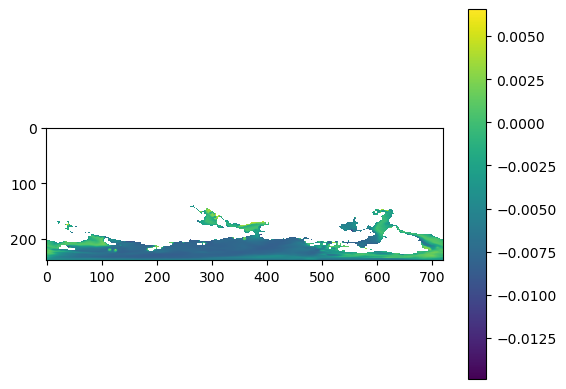

In [34]:
plt.imshow(ds_eofs.sel(EOF=0)[var_name])
plt.colorbar()

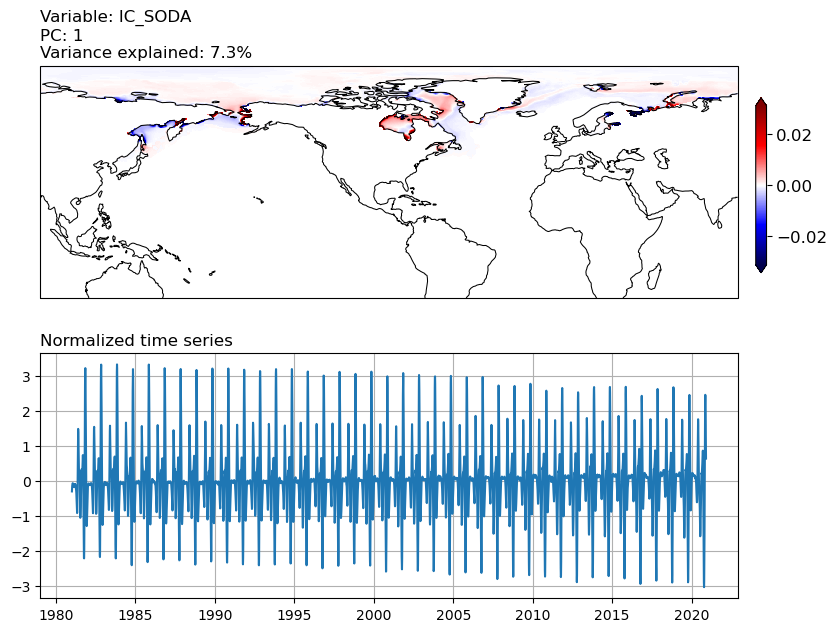

In [37]:
ipc = 1
temp_eof = ds_eofs.sel(EOF=ipc)[var_name]

##########PLOT MAP #####################
symmetric_max = np.nanmax([abs(np.nanpercentile(temp_eof,0.5)),abs(np.nanpercentile(temp_eof,99.5))])
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(211,projection=ccrs.PlateCarree(central_longitude=-90+360))

# print(vmax,vmin)
cs = plt.pcolormesh(temp_eof.lon,temp_eof.lat,\
    temp_eof.values,cmap='seismic',
    transform=ccrs.PlateCarree(),vmin=-symmetric_max,vmax=symmetric_max)
ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)

plt.xlim()

plt.title(f'Variable: {name_var}\nPC: {ipc}\nVariance explained: {round(pca_obj.explained_variance_ratio_[ipc] * 100,2)}%',loc='left')

cbar_ax = fig.add_axes([0.92, 0.575,0.012,0.25])
cbar = fig.colorbar(cs,cax=cbar_ax,orientation='vertical', extend='both')
cbar.ax.tick_params(labelsize=12)
# cbar.set_label(trend.units, fontsize=14)
ax2 = fig.add_subplot(212)
ax2.plot(transformed_da[ipc])
ax2.grid()
plt.title(f'Normalized time series',loc='left')
plt.show()

In [17]:
for 



In [19]:
unstacked_pc.shape

(240, 720)

In [ ]:
pc_flattened_nonan.values = pca_obj.components_

In [10]:
pca_obj.components_

array([[-4.21227722e-03, -3.79199294e-03, -4.21377187e-03, ...,
        -3.14073040e-03, -3.17631089e-03, -3.20537586e-03],
       [-2.91860436e-04, -3.20605511e-04, -2.91860710e-04, ...,
        -9.67525756e-05, -1.04700908e-04, -1.11610584e-04],
       [-1.67301177e-03, -1.63127562e-03, -1.67328260e-03, ...,
        -1.22941241e-04, -1.25630573e-04, -1.27969911e-04],
       ...,
       [ 5.38857740e-03,  5.93928859e-03,  5.39068360e-03, ...,
        -4.85639187e-03, -5.28881848e-03, -5.66891632e-03],
       [ 4.90109341e-03,  4.23545161e-03,  4.91373272e-03, ...,
        -5.56783207e-03, -5.26272225e-03, -4.98903602e-03],
       [ 9.78359536e-04,  1.98401675e-03,  9.58639496e-04, ...,
         4.38543953e-03,  4.15034418e-03,  3.93404768e-03]])

In [ ]:
ipc = 0

pc_flattened_nonan = copy.deepcopy(flattened_nonan.isel(time=0))#.values
# flattened_nonan.isel(time=0).values = pca_obj.components_[0]
pc_flattened_nonan.values = pca_obj.components_[ipc]
pc_flattened = copy.deepcopy(flattened_da.isel(time=0))
array_temp = copy.deepcopy(pc_flattened.values)
array_temp[where_nonan] = pc_flattened_nonan.values
pc_flattened.values  = array_temp
unstacked_pc = pc_flattened.unstack('flat')

In [ ]:
ipc = 0

pc_flattened_nonan = copy.deepcopy(flattened_nonan.isel(time=0))#.values
# flattened_nonan.isel(time=0).values = pca_obj.components_[0]
pc_flattened_nonan.values = pca_obj.components_[ipc]
pc_flattened = copy.deepcopy(flattened_da.isel(time=0))
array_temp = copy.deepcopy(pc_flattened.values)
array_temp[where_nonan] = pc_flattened_nonan.values
pc_flattened.values  = array_temp
unstacked_pc = pc_flattened.unstack('flat')

##########PLOT MAP #####################
symmetric_max = np.nanmax([abs(np.nanpercentile(unstacked_pc.values,0.5)),abs(np.nanpercentile(unstacked_pc.values,99.5))])
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(211,projection=ccrs.PlateCarree(central_longitude=-90+360))

# print(vmax,vmin)
cs = plt.pcolormesh(unstacked_pc.lon,unstacked_pc.lat,\
    unstacked_pc.values,cmap='seismic',
    transform=ccrs.PlateCarree(),vmin=-symmetric_max,vmax=symmetric_max)
ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)

plt.xlim()

plt.title(f'Variable: {name_var}\nPC: {ipc}\nVariance explained: {round(pca_obj.explained_variance_ratio_[ipc] * 100,2)}%',loc='left')

cbar_ax = fig.add_axes([0.92, 0.575,0.012,0.25])
cbar = fig.colorbar(cs,cax=cbar_ax,orientation='vertical', extend='both')
cbar.ax.tick_params(labelsize=12)
# cbar.set_label(trend.units, fontsize=14)
ax2 = fig.add_subplot(212)
ax2.plot(transformed_da[ipc])
ax2.grid()
plt.title(f'Normalized time series',loc='left')
plt.show()

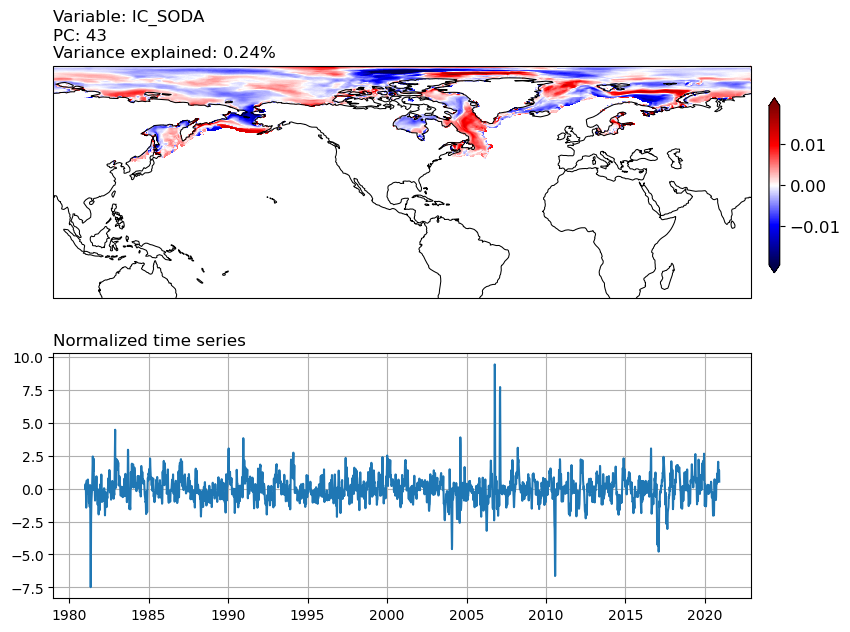

In [35]:
##########PLOT MAP #####################
symmetric_max = np.nanmax([abs(np.nanpercentile(unstacked_pc.values,0.5)),abs(np.nanpercentile(unstacked_pc.values,99.5))])
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(211,projection=ccrs.PlateCarree(central_longitude=-90+360))

# print(vmax,vmin)
cs = plt.pcolormesh(unstacked_pc.lon,unstacked_pc.lat,\
    unstacked_pc.values,cmap='seismic',
    transform=ccrs.PlateCarree(),vmin=-symmetric_max,vmax=symmetric_max)
ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)

plt.xlim()

plt.title(f'Variable: {name_var}\nPC: {ipc}\nVariance explained: {round(pca_obj.explained_variance_ratio_[ipc] * 100,2)}%',loc='left')

cbar_ax = fig.add_axes([0.92, 0.575,0.012,0.25])
cbar = fig.colorbar(cs,cax=cbar_ax,orientation='vertical', extend='both')
cbar.ax.tick_params(labelsize=12)
# cbar.set_label(trend.units, fontsize=14)
ax2 = fig.add_subplot(212)
ax2.plot(transformed_da[ipc])
ax2.grid()
plt.title(f'Normalized time series',loc='left')
plt.show()

In [9]:
def detect_outliers_zscore(data, threshold=4):
    """
    Detect outliers in a univariate dataset using the Z-score method.

    Parameters:
    - data: A 1D numpy array representing the time series data.
    - threshold: The threshold value for the Z-score. Data points with a Z-score greater than this value are considered outliers.

    Returns:
    - An array of indices corresponding to the outliers.
    """
    z_scores = (data - np.mean(data)) / np.std(data)
    outlier_indices = np.where(np.abs(z_scores) > threshold)[0]
    return outlier_indices

In [11]:
for ifile in range(len(files_weekly_anoms)):
# for ifile in range(13, 22):
# for ifile in [10,20,21]:
# for ifile in [8]:
    file_temp = files_weekly_anoms[ifile]
    dataset = xr.open_dataset(file_temp)
    var_name = list(dataset.data_vars.keys())[0]
    print(file_temp,var_name)
    dataset = dataset.load()

    name_var = file_temp.split('/')[-1][:-3]
    flattened_da = dataset.stack(flat=('lat','lon')).transpose('time','flat')[var_name]
    flattened_da_clean = copy.deepcopy(flattened_da)
    
    nan_mask = flattened_da.isnull().any(dim='time')
    where_nonan = np.where(nan_mask==False)[0]

    if ('SSH' in file_temp)|\
        ('OHC' in file_temp)|\
        ('Z500' in file_temp)|\
        ('OLR' in file_temp)|\
        ('SST' in file_temp)|\
        ('U10' in file_temp)|\
        ('U200' in file_temp):
        pass
    else:
        for icolumn in where_nonan:
            series_temp = pd.Series(flattened_da_clean[:,icolumn],index=flattened_da_clean[:,icolumn].time)
            series_temp = series_temp[series_temp.index.dayofweek == 0]
        
            rolling_mean = series_temp.rolling(timedelta(days=180),center=True).mean()
            # rolling_std = rolling_mean.rolling(timedelta(days=30),center=True).std()
            # outliers  = detect_outliers_zscore(rolling_std)
            diff = rolling_mean.diff()
            outliers  = detect_outliers_zscore(diff)
            if len(outliers)>=5:
                flattened_da_clean[:, icolumn] = np.nan
            
    clean_dataset = flattened_da_clean.unstack('flat')
    flattened_da = clean_dataset.stack(flat=('lat','lon')).transpose('time','flat')#[var_name]
    # nan_mask = flattened_da.isnull().all(dim='time')
    nan_mask = flattened_da.isnull().any(dim='time')
    where_nonan = np.where(nan_mask==False)[0]
    flattened_nonan = flattened_da[:,where_nonan]
    flattened_nonan = flattened_nonan.where(flattened_nonan >= -10, 0)
    flattened_nonan = flattened_nonan.where(flattened_nonan <= 10, 0)
    if 'OLR' in file_temp:
        flattened_nonan = flattened_nonan*(-1)
    # aaaa
    # create pca object
    pca_obj = PCA(20, whiten=True)##
    pca_obj = pca_obj.fit(flattened_nonan)

    # transform era5 data with pca
    transformed_da = pca_obj.transform(flattened_nonan)

    print(f'number of pcs: {len(pca_obj.explained_variance_ratio_)}')
    transformed_da = pd.DataFrame(transformed_da,index = dataset.time)


    df_wr_temp = df_shifts['week0'].dropna()
    mean_hist_wrs = np.histogram(df_wr_temp,bins=np.arange(-0.5,5,1))[0]
    mean_hist_wrs = mean_hist_wrs/np.sum(mean_hist_wrs)

    try: os.mkdir(f'/glade/u/home/jhayron/WR_Predictability/6_PCA_xgboost/figures_detrended_20240317/{name_var}/')
    except: pass

    transformed_da.to_csv(f'/glade/u/home/jhayron/WR_Predictability/6_PCA_xgboost/figures_detrended_20240317/{name_var}/PC_{name_var}.csv')
    
    try: os.mkdir(f'/glade/u/home/jhayron/WR_Predictability/6_PCA_xgboost/data_pcs/Heatmaps/{name_var}/')
    except: pass
    try: os.mkdir(f'/glade/u/home/jhayron/WR_Predictability/6_PCA_xgboost/data_pcs/TimeSeries/{name_var}/')
    except: pass
    try: os.mkdir(f'/glade/u/home/jhayron/WR_Predictability/6_PCA_xgboost/data_pcs/EOFs/{name_var}/')
    except: pass
    transformed_da.to_csv(f'/glade/u/home/jhayron/WR_Predictability/6_PCA_xgboost/data_pcs/TimeSeries/{name_var}/PC_{name_var}.csv')            
    for ipc in range(len(pca_obj.explained_variance_ratio_)):
        # print(f'PC: {ipc}**********************')
        ##########Unstack PC #####################
        pc_flattened_nonan = copy.deepcopy(flattened_nonan.isel(time=0))#.values
        # flattened_nonan.isel(time=0).values = pca_obj.components_[0]
        pc_flattened_nonan.values = pca_obj.components_[ipc]
        pc_flattened = copy.deepcopy(flattened_da.isel(time=0))
        array_temp = copy.deepcopy(pc_flattened.values)
        array_temp[where_nonan] = pc_flattened_nonan.values
        pc_flattened.values  = array_temp
        unstacked_pc = pc_flattened.unstack('flat')
        unstacked_pc.to_netcdf(f'/glade/u/home/jhayron/WR_Predictability/6_PCA_xgboost/data_pcs/EOFs/{name_var}/EOF_{ipc}.nc')
        ##########PLOT MAP #####################
        quintiles = np.percentile(transformed_da[ipc], [20, 40, 60, 80])
        median_series = np.median(transformed_da[ipc])
        
        ##########Normalize PC #####################
        normalized_pc = transformed_da[ipc]#/np.nanmax(abs(transformed_da[ipc]))
        normalized_pc.index = normalized_pc.index.floor('D')

        ##########Get conditional histogram for each bin within PC #####################
        bins = np.percentile(normalized_pc,[0,20,40,60,80,100])
        np.save(f'/glade/u/home/jhayron/WR_Predictability/6_PCA_xgboost/data_pcs/TimeSeries/{name_var}/bins_{ipc}.npy',bins)
        mid_bins = np.array([10,30,50,70,90])

        avg_change_bins_weeks = np.zeros([len(mid_bins),len([1,2,3,4,5,6,7,8])])
        p_val_bins_weeks = np.zeros([len(mid_bins),len([1,2,3,4,5,6,7,8])])
        
        for week in [1,2,3,4,5,6,7,8]:
            df_pc_wr = pd.concat([normalized_pc,df_shifts[f'week{week}']],axis=1).dropna()
            p_values = []
            prob2d = np.zeros([5,len(mid_bins)])
            for ibin in range(len(bins)-1):
                # print(bin_center)
                df_temp = df_pc_wr[(df_pc_wr[ipc]>=bins[ibin])&(df_pc_wr[ipc]<=bins[ibin+1])][f'week{week}']
                hist_temp = np.histogram(df_temp,bins=np.arange(-0.5,5,1))[0]
                hist_temp = hist_temp/np.sum(hist_temp)
                diff_temp = hist_temp - mean_hist_wrs
                prob2d[:,ibin] = diff_temp
                
                freq_table_A = df_wr_temp.value_counts().sort_index()##
                freq_table_B = df_temp.value_counts().sort_index()##
                observed = pd.concat([freq_table_A, freq_table_B], axis=1).fillna(0).values##
                chi2, p, _, _ = chi2_contingency(observed)##
                p_values.append(p)##
            p_values = np.array(p_values)##

            avg_hist_change_for_week = np.mean(abs(prob2d),axis=0)
            p_val_bins_weeks[:,week-1] = p_values
            avg_change_bins_weeks[:,week-1] = avg_hist_change_for_week
            np.save(f'/glade/u/home/jhayron/WR_Predictability/6_PCA_xgboost/data_pcs/Heatmaps/{name_var}/prob2d_{ipc}_{week}.npy',prob2d)
        
        np.save(f'/glade/u/home/jhayron/WR_Predictability/6_PCA_xgboost/data_pcs/Heatmaps/{name_var}/avg_change_bins_weeks_{ipc}.npy',avg_change_bins_weeks)
        np.save(f'/glade/u/home/jhayron/WR_Predictability/6_PCA_xgboost/data_pcs/Heatmaps/{name_var}/p_val_bins_weeks_{ipc}.npy',p_val_bins_weeks)


/glade/derecho/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd/IC_SODA.nc cn_total_anomalies
number of pcs: 20
/glade/derecho/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd/IT_SODA.nc hi_anomalies
number of pcs: 20
/glade/derecho/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd/MLD_SODA.nc mlt_anomalies
number of pcs: 20
/glade/derecho/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd/OHC100_SODA.nc ocean_heat_content_anomalies
number of pcs: 20
/glade/derecho/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd/OHC200_SODA.nc ocean_heat_content_anomalies
number of pcs: 20
/glade/derecho/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd/OHC300_SODA.nc ocean_heat_content_anomalies
number of pcs: 20
/glade/derecho/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd/OHC50_SODA.nc ocean_heat_content_anomalies
number of pcs: 20
/glade/derecho/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd/OHC700_SODA

In [ ]:
transformed_da